In [1]:
import json
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple, OrderedDict

In [2]:
sys.path.insert(0, '../src/lib')

In [3]:
from utils.geometry import create_camera_matrix, euler_angles_to_rotation_matrix, euler_angles_to_quaternions, quaternion_to_euler_angle, quaternion_upper_hemispher, rotate
from utils.image import affine_transform, get_affine_transform, draw_msra_gaussian, draw_umich_gaussian, gaussian_radius, pad_img_sides
from utils.kaggle_cars_utils import parse_annot_str

In [4]:
INPUT_PATH = '../data/pku-autonomous-driving'

In [5]:
def read_split_file(split, data_dir=INPUT_PATH):
    path = os.path.join(data_dir, 'split', split+'.txt')
    with open(path) as f:
        return [line.rstrip('\n')[:-4] for line in f]


def load_annotations(df, img_ids):
    anns = []
    for img_id in img_ids:
        for car in gen_img_annotation(img_id, df):
            anns.append(car['rotation'])
    return anns


def gen_img_annotation(img_id, df):
    cond = df['ImageId'] == img_id
    cars = df.loc[cond, 'PredictionString'].values[0]
    cars = parse_annot_str(str(cars))
    return cars

In [6]:
def plot_distr(df, col, figsize=(15,3)):
    plt.figure(figsize=figsize)
    sns.distplot(df[col], bins=500);
    plt.xlabel(col)
    plt.show()

In [7]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
img_ids = read_split_file('train') + read_split_file('val')
rot_e3 = load_annotations(df, img_ids)
len(img_ids), len(rot_e3)

(4262, 49684)

In [8]:
bad_match_idx = []
eq_thresh = 2e-7

for i, rot0 in enumerate(rot_e3):
    q = euler_angles_to_quaternions(rot0)[0]
    q = quaternion_upper_hemispher(q)
    rot1 = quaternion_to_euler_angle(q)
    
    rot_diff = rot1 - rot0
    
    if (rot_diff > eq_thresh).any():
        bad_match_idx.append(i)
        
len(bad_match_idx)

0

In [9]:
rot_df = pd.DataFrame(np.empty((len(rot_e3), 7)), columns=['yaw', 'pitch', 'roll', 'q0', 'q1', 'q2', 'q3'])

In [10]:
for i in range(len(rot_e3)):
    r3 = rot_e3[i]
    r3 = np.copy(r3)
    r3[1] = rotate(r3[1], np.pi/2)
    r3[2] = rotate(r3[2], np.pi/2)
    rot_df.iloc[i,:3] = r3
    q = euler_angles_to_quaternions(r3)[0]
    q = quaternion_upper_hemispher(q)
    rot_df.iloc[i,3:] = q

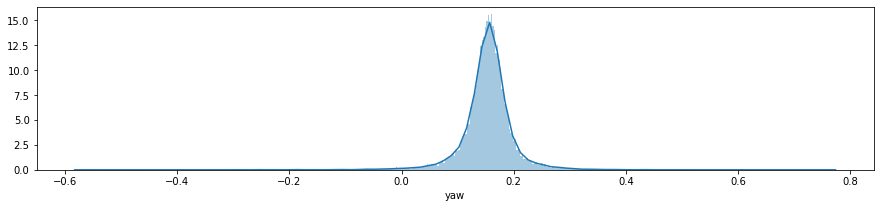

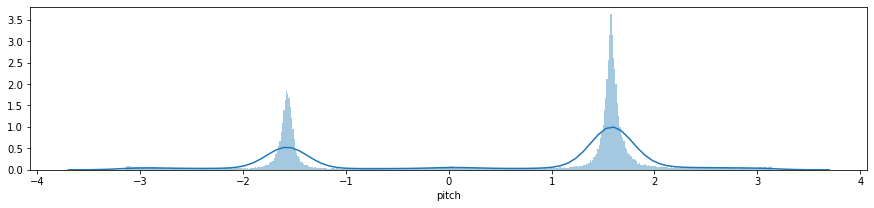

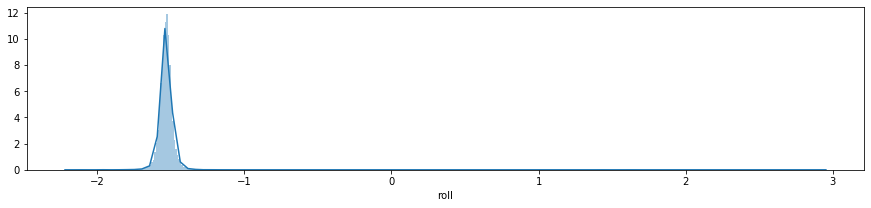

In [11]:
for c in ['yaw', 'pitch', 'roll']:
    plot_distr(rot_df, c)

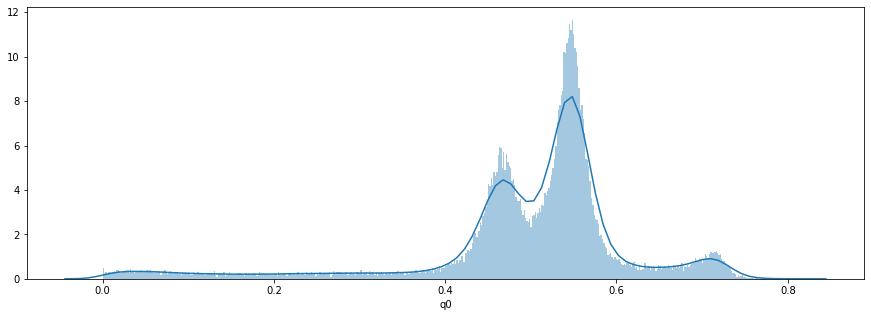

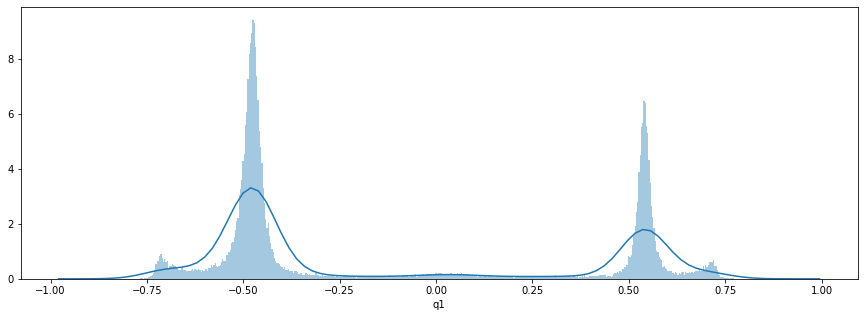

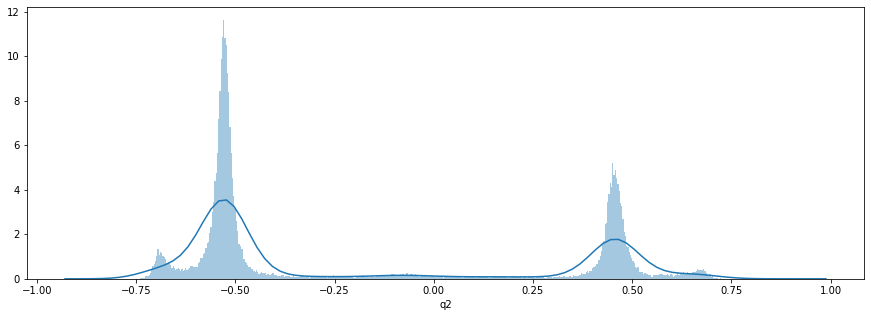

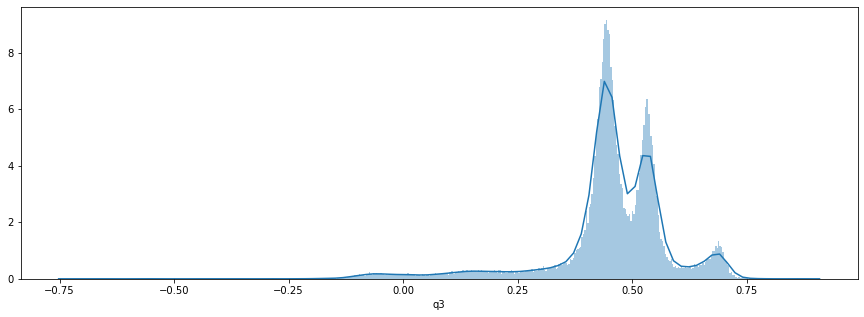

In [12]:
for c in ['q0', 'q1', 'q2', 'q3']:
    plot_distr(rot_df, c, figsize=(15,5))